# Exercise Chapter 6 
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import math
import mistat
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import tsatools
import statsmodels.formula.api as smf

# Exercise 2

In [3]:
seascom = mistat.load_data('SEASCOM.csv')
df = tsatools.add_trend(seascom, trend='ct')
df['season_1'] = [np.cos(math.pi * tx/6) for tx in df['trend']]
df['season_2'] = [np.sin(math.pi * tx/6) for tx in df['trend']]
print(df.head())

model = smf.ols(formula='SeasCom ~ trend + 1 + season_1 + season_2',
                data=df).fit()
print(model.params)
print(f'r2-adj: {model.rsquared_adj:.3f}')

    SeasCom  const  trend      season_1  season_2
0  71.95623    1.0    1.0  8.660254e-01  0.500000
1  56.36048    1.0    2.0  5.000000e-01  0.866025
2  64.85331    1.0    3.0  6.123234e-17  1.000000
3  59.93460    1.0    4.0 -5.000000e-01  0.866025
4  51.62297    1.0    5.0 -8.660254e-01  0.500000
Intercept    47.673469
trend         1.047236
season_1     10.653968
season_2     10.130145
dtype: float64
r2-adj: 0.981


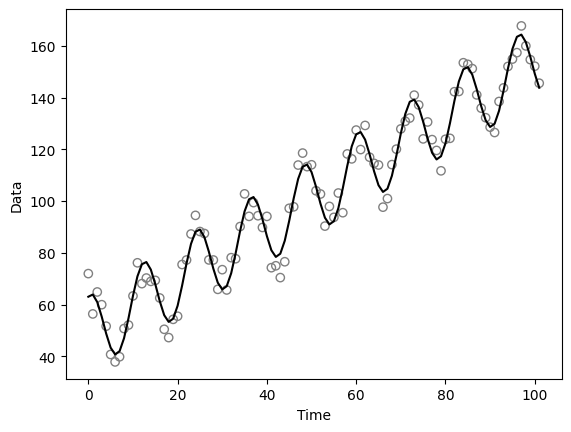

In [4]:
seascom = mistat.load_data('SEASCOM.csv')
fig, ax = plt.subplots()
ax.scatter(seascom.index, seascom, facecolors='none', edgecolors='grey')
model.predict(df).plot(ax=ax, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Data')
plt.show()

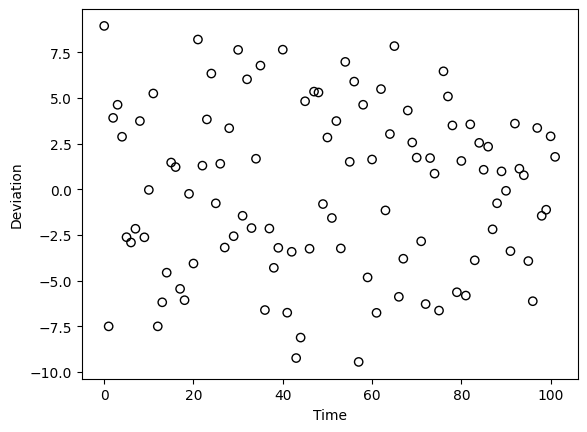

In [5]:
U = df['SeasCom'] - model.predict(df)
fig, ax = plt.subplots()
ax.scatter(U.index, U, facecolors='none', edgecolors='black')
ax.set_xlabel('Time')
ax.set_ylabel('Deviation')
plt.show()

In [6]:
# use slices to get sublists
corr_1 = np.corrcoef(U[:-1], U[1:])[0][1]
corr_2 = np.corrcoef(U[:-2], U[2:])[0][1]
print(f'Corr(Ut,Ut-1) = {corr_1:.3f}')
print(f'Corr(Ut,Ut-2) = {corr_2:.3f}')

Corr(Ut,Ut-1) = -0.191
Corr(Ut,Ut-2) = 0.132


In [7]:
# keep some information for later exercises
seascom_model = model
seascom_df = df

# Exercise 4

In [8]:
beta = np.array([1, 1.05, 0.76, -0.35, 0.45, 0.55])
data = []
n = len(beta)
sum_0 = np.sum(beta * beta)
for h in range(6):
  sum_h = np.sum(beta[:n-h] * beta[h:])
  data.append({
    'h': h,
    'K(h)': sum_h,
    'rho(h)': sum_h / sum_0,
  })

In [9]:
df = pd.DataFrame(data)
s = df[['K(h)', 'rho(h)']].transpose().style
s = s.format(precision=3)
s

,0,1,2,3,4,5
K(h),3.308,1.672,0.542,0.541,1.028,0.550
rho(h),1.000,0.506,0.164,0.163,0.311,0.166


# Exercise 11

In [10]:
dow1941 = mistat.load_data('DOW1941.csv')

X = dow1941.values # extract values to remove index for calculations
Y = X[2:] - 2 * X[1:-1] + X[:-2]

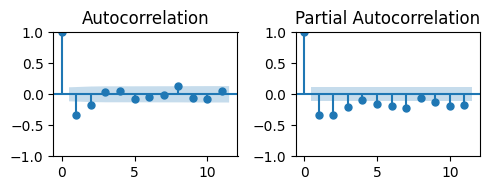

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=[5, 2])
plot_acf(Y, lags=11, ax=axes[0])
plot_pacf(Y, lags=11, method='ywm', ax=axes[1])
plt.tight_layout()
plt.show()

In [12]:
# use argument alpha to return confidence intervals
y_acf, ci_acf = acf(Y, nlags=11, fft=True, alpha=0.05)
y_pacf, ci_pacf = pacf(Y, nlags=11, alpha=0.05)

# determine if values are significantly different from zero
def is_significant(y, ci):
    return not (ci[0] < 0 < ci[1])

s_acf = [is_significant(y, ci) for y, ci in zip(y_acf, ci_acf)]
s_pacf = [is_significant(y, ci) for y, ci in zip(y_pacf, ci_pacf)]

In [13]:
sn = {True: 'S', False: 'NS'}
print(' h        acf    S/NS      pacf   S/NS')
for i in range(len(y_acf)):
    if i == 0:
         continue
    print(f'{i:2d}   {y_acf[i]:8.3f}    {sn[s_acf[i]]:2s}', end='')
    print(f'    {y_pacf[i]:8.3f}   {sn[s_pacf[i]]:2s}')

 h        acf    S/NS      pacf   S/NS
 1     -0.342    S       -0.343   S 
 2     -0.179    S       -0.337   S 
 3      0.033    NS      -0.210   S 
 4      0.057    NS      -0.100   NS
 5     -0.080    NS      -0.155   S 
 6     -0.047    NS      -0.193   S 
 7     -0.010    NS      -0.237   S 
 8      0.128    NS      -0.074   NS
 9     -0.065    NS      -0.127   S 
10     -0.071    NS      -0.204   S 
11      0.053    NS      -0.193   S 


# Exercise 12

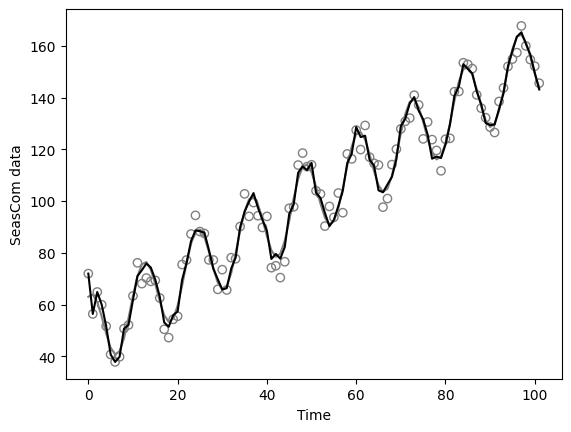

In [14]:
predictedError = mistat.optimalLinearPredictor(seascom_model.resid,
                      10, nlags=9)
predictedTrend = seascom_model.predict(seascom_df)
correctedTrend = predictedTrend + predictedError

fig, ax = plt.subplots()
ax.scatter(seascom_df.index, seascom_df['SeasCom'],
           facecolors='none', edgecolors='grey')
predictedTrend.plot(ax=ax, color='grey')
correctedTrend.plot(ax=ax, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('SeasCom data')
plt.show()